# Structured and quadtree mesh generation from an existing raster

This notebook presents a number of methods to generate structured and unstructured meshes with a DEM raster as the primary input source for the data. Much of the mesh generation is done with FloPy, however we use "D-Any" methods to define the initial watershed boundary locations and to do flow accumulation in these examples.


In [1]:
import pathlib as pl
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import dany
import flopy
import dataretrieval.nwis as nwis

from shapely.geometry import LineString
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

## Structured grid from a raster

A structured rectilinear mesh (grid) can be built from a raster using some simple math. The data we produce from this grid can then be used to generate more complex meshes.

Load up the raster to begin

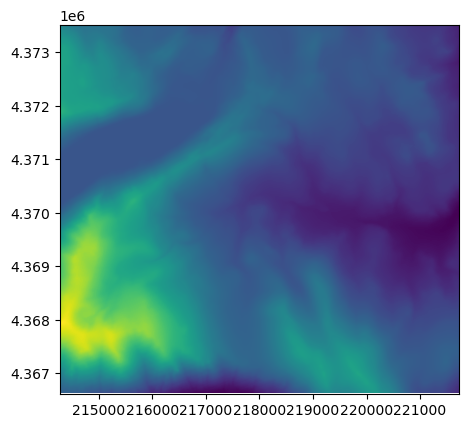

In [2]:
raster = pl.Path("../data/dem.img")

rstr = flopy.utils.Raster.load(raster)
rstr.plot();

Get information about the raster to generate the structured grid

In [3]:
xmin, xmax, ymin, ymax = rstr.bounds
epsg = rstr.crs.to_epsg()

Build the grid

In [4]:
dx = 100
dy = 100
nlay = 1
ncol = int(np.floor((xmax - xmin) / dx))
nrow = int(np.floor((ymax - ymin) / dy))
delr = np.full((ncol,), dx)
delc = np.full((nrow,), dy)
top = np.ones((nrow, ncol))
botm = np.zeros((nlay, nrow, ncol))
idomain = np.ones(botm.shape, dtype=int)

sgrid = flopy.discretization.StructuredGrid(
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    xoff=xmin,
    yoff=ymin,
    crs=f"EPSG:{epsg}"
)

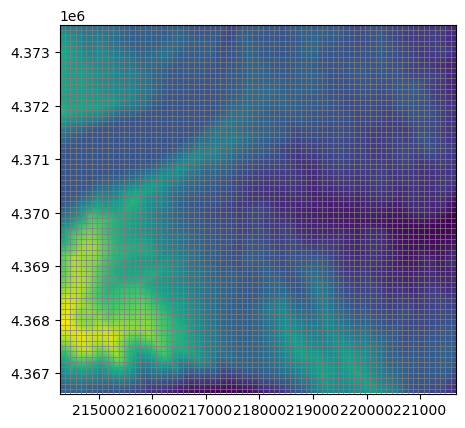

In [5]:
fig, ax = plt.subplots()
rstr.plot(ax=ax)
sgrid.plot(ax=ax, lw=0.5);

Now we have a basic structured grid mesh to begin working with.

Rasters can be resampled to a grid using the `resample_to_grid()` method on the raster object

In [6]:
dem = rstr.resample_to_grid(
    sgrid,
    band=rstr.bands[0],
    method="min"
)

And now flow directions, flow accumulation, and basin boundaries can be calculated from the resampled raster data. Note we will be using the basin boundary or the existing structured grid as an input to generate more complex meshes.

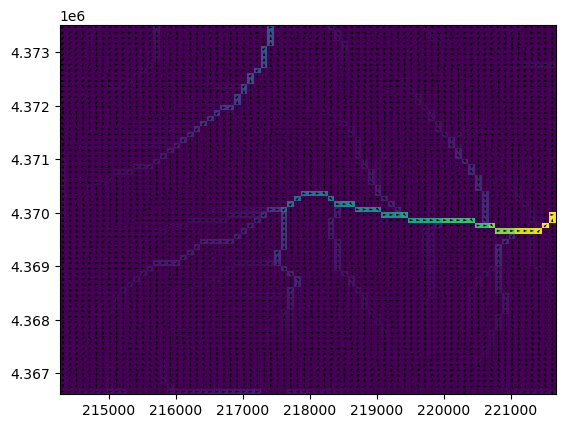

In [7]:
filled_dem = dany.fill_sinks(sgrid, dem, eps=2e-06)
fdobj = dany.FlowDirections(sgrid, filled_dem)
fdir = fdobj.flow_directions()
facc = fdobj.flow_accumulation(as_cells=True)

qx, qy = fdobj.vectors

fig, ax = plt.subplots()
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_array(facc)
v = pmv.plot_vector(qx, qy);

The user can also get a gage location or set their own "pour point" location for catchment delineation

This example uses the "dataretrieval-python" package to stream gage information from the National Water Informaiton System (NWIS). For this, we'll need to dissolve the grid and get the bounding box of the model grid in decimal lat/lon. We can use geopandas for this.

In [8]:
gdf = sgrid.geo_dataframe
gdf = gdf.set_crs(epsg=epsg)
gdf = gdf.to_crs(epsg=4326)
gdf = gdf.dissolve()
bBox = [f"{i :.2f}" for i in gdf.bounds.values[0]]

# put data into geodataframe for plotting and examining
nwisdf, meta = nwis.get_info(bBox=bBox)
geoms = gpd.points_from_xy(nwisdf.dec_long_va.values, nwisdf.dec_lat_va.values)
nwisdf = gpd.GeoDataFrame(nwisdf, geometry=geoms, crs="EPSG:4326")
nwisdf = nwisdf.to_crs(epsg=epsg)
nwisdf["site_tag"] = range(len(nwisdf))
nwisdf.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry,site_tag
0,USGS,10342900,INDEPENDENCE LK NR TRUCKEE CA,LK,392707.0,1201723.00,39.451849,-120.290759,M,F,...,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (216838.857 4372090.800),0
1,USGS,10343000,INDEPENDENCE C NR TRUCKEE CA,ST,392724.0,1201710.00,39.456572,-120.287148,M,F,...,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (217168.780 4372603.691),1
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.00,39.431572,-120.237979,M,F,...,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (221300.455 4369675.125),2
3,USGS,392501120182800,SAGEHEN CR NR CARPENTER RIDGE CA,ST,392501.0,1201828.00,39.416849,-120.308814,M,S,...,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (215142.248 4368262.160),3
4,USGS,392553120142301,NADP NTN CA50 A SAGEHEN CREEK NR TRUCKEE CA,AT,392553.4,1201422.92,39.431500,-120.239700,M,M,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,NADP,POINT (221152.033 4369672.406),4


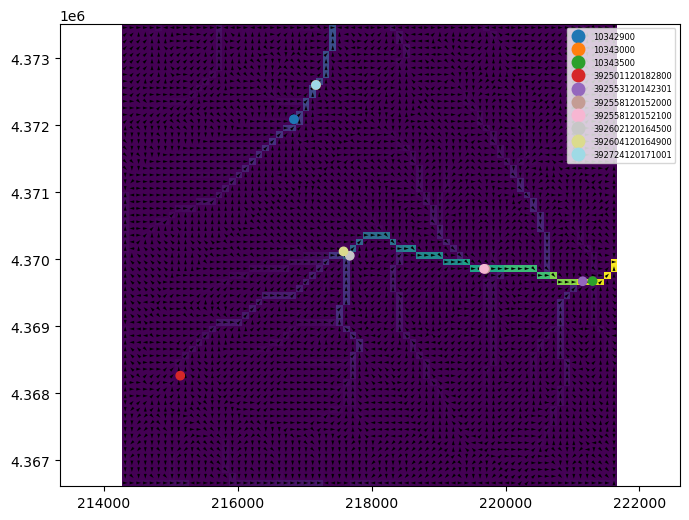

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_array(facc)
v = pmv.plot_vector(qx, qy)
nwisdf.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

For this example, site 10343500 is going to be used to define the downstream end of the catchment

In [10]:
site = nwisdf.loc[nwisdf["site_no"] == "10343500"]
idomain = fdobj.get_watershed_boundary(site.geometry.values[0])

# and update the grid with this data
sgrid._idomain = np.array([idomain], dtype=int)

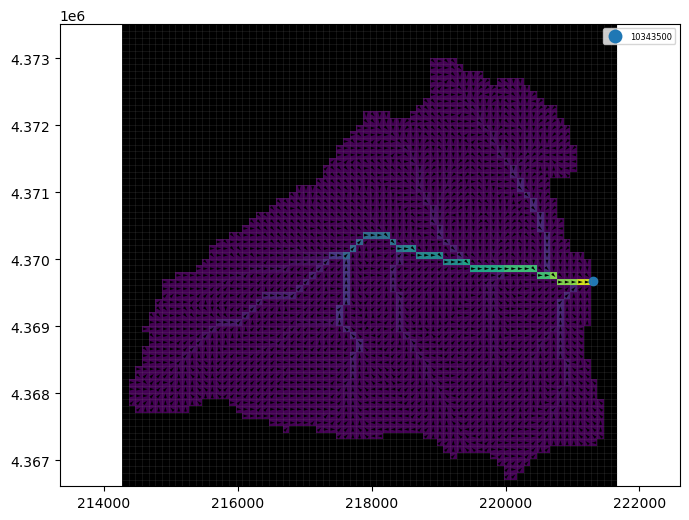

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("equal")
pmv = flopy.plot.PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_array(facc)
pmv.plot_inactive()
v = pmv.plot_vector(qx, qy)
pmv.plot_grid(lw=0.5, alpha=0.2)
site.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6});

Delineate streams and create stream linework

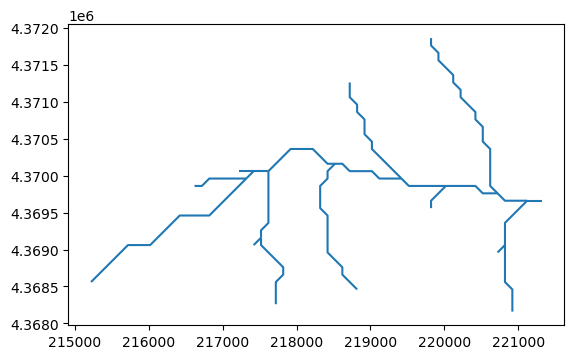

In [12]:
strms = dany.PrmsStreams(sgrid, fdobj)
strm_array = strms.delineate_streams(contrib_area=85, basin_boundary=sgrid.idomain[0]).astype(float)
vectors = strms.create_stream_vectors()

gdf_strm = gpd.GeoDataFrame(
    {"segment": [i for i in sorted(vectors.keys())]}, 
    geometry=[LineString(v) for _, v in sorted(vectors.items())], 
    crs=f"EPSG:{epsg}"
)
gdf_strm.plot();

## Generating Quadtree mesh for local refinement

This example will show how to go from an existing model discretization (grid/mesh) to a quadtree refined mesh using FloPy. We will develop our quadtree grid from the `sgrid` object and do local quadtree refinement around the streams.

The `Gridgen` utility in FloPy will be used to create this grid

In [13]:
from flopy.utils.gridgen import Gridgen

temp_path = pl.Path("./temp")
temp_path.mkdir(exist_ok=True)
g = Gridgen(sgrid, model_ws=temp_path)

for geom in gdf_strm.geometry.values:
    g.add_refinement_features([geom,], "line", 1, range(1))
g.build()

Now results from `Gridgen` can be used to create a `VertexGrid` object

In [14]:
quadgrid = flopy.discretization.VertexGrid(**g.get_gridprops_vertexgrid())

Raster resampling to the refined grid

In [15]:
dem = rstr.resample_to_grid(
    quadgrid,
    band=rstr.bands[0],
    method="min"
)

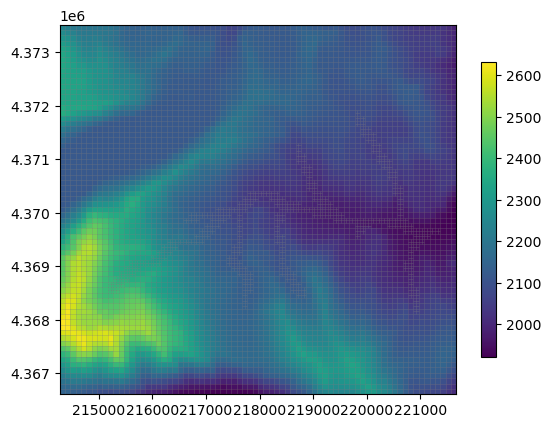

In [16]:
fig, ax = plt.subplots()
pmv = flopy.plot.PlotMapView(modelgrid=quadgrid, ax=ax)
pc = pmv.plot_array(dem)
pmv.plot_grid(lw=0.5, alpha=0.2)
plt.colorbar(pc, shrink=0.8);

And now to calculate flow directions, flow accumulation, and the watershed boundary

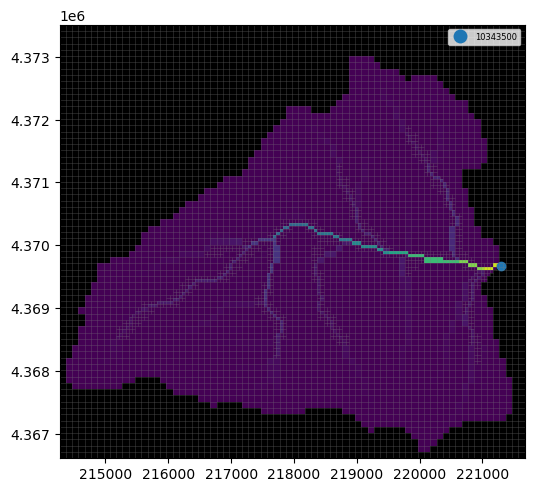

In [19]:
filled_dem = dany.fill_sinks(quadgrid, dem, eps=2e-06)
fdobj = dany.FlowDirections(quadgrid, filled_dem)
fdir = fdobj.flow_directions()
facc = fdobj.flow_accumulation()
watershed = fdobj.get_watershed_boundary(site.geometry.values[0])

quadgrid._idomain = np.array([watershed], dtype=int)

fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(modelgrid=quadgrid, ax=ax)
pmv.plot_array(facc)
pmv.plot_inactive()
site.plot(column="site_no", ax=ax, cmap="tab20", legend=True, legend_kwds={"fontsize":6})
pmv.plot_grid(lw=0.5, alpha=0.2);